In [ ]:
# Uncomment if use Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #mount google drive


Mounted at /content/gdrive


In [ ]:
# Nothing better to begin with than by importing some necessary dependencies. 
%matplotlib inline
import torch
import matplotlib.pyplot as plt

# ECS269U/P - Coursework


* The **goal** of the CW is similar to that of Week 2's Lab: fitting a curve to data, also known as **curve fitting**. 
* This has applications in many different disciplines that make use of AI: FinTech, Physics Modelling, or even Sports. 
* For example, we might be interested in learning the evolution (over time) of the price of a specific product in different countries. This can depend on several factors: the product itself, the country, the initial value of the product's price, etc. 
* As usual, we are interested in learning a model that finds these relationships *from the data*. 


### Learning a family of functions

* The main difference with Week 2's Lab is that we will learn a network that does not learn a single function but a *family of functions*.
* We will consider a family of sinusoidal functions. 
* Below you can find the code generating the data according to different random sinusoidal functions $\{f_a\}$. We randomly generate a set of 40 points in the x-axis in the interval $[-2, 2]$, slightly randomly shifted. Our functions will have the form of $y = f_a(x) = a * sin(x+a)$ where each $a$ will be randomly sampled for each function from interval $[-2, 2]$.  To "draw" a function $f_a$, we first choose some $a \sim U(-2,2)$ and then we compute $f_a$ using the above formula for all the $x$ in the x-axis. 


In [ ]:
Nf = 2000 # the number of different functions f that we will generate
Npts = 40 # the number of x values that we will use to generate each fa
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)

x += torch.rand_like(x)*0.1
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
y = a*torch.sin(x+a)

## The Learning Goal

* Because we are dealing with a family of functions and not just a single function, our model must be able to perform two tasks: *Function Selection* and *Regression*.
* Function selection means that given some *additional* input (to be defined below) the model somehow must choose which function $f_a$ from the family of functions $\{f_a\}$ it needs to model.
* Once the correct function is picked then the model must perform regression i.e. learn the relationship $y=f_a(x)$.




## The Learning Objective

* During training we randomly sample functions from the family of functions $\{f_a\}$. For each $f_a$, we are provided with the (input, output) pairs $(x_t, y_t), t=1,\dots,N_{pts}$.

* To perform *Function Selection*, a **random subset** of $(x_t, y_t), t=1,\dots,N_{pts}$ is provided as auxiliary input to the model during *both training and testing*. These auxiliary data is called the *context data:* $(x_c, y_c), c=1,\dots,N_c$. 

* Note that the total number of context points $N_c$ should be different (and randomly chosen) for every batch so that the model learns to handle different number of context points at test time. This means that the model should be able to work for e.g. $N_c=5$ but also for $N_c=12$ etc.

* Our model will take the context pairs $(x_c, y_c)$ and input values $x_t$ and will produce the estimated values $\hat{y}_t$. 

* During training we have access to the ground-truth values $y_t$, and thus we can compute a loss between the model's predictions $\hat{y}_t$ and the ground-truth values $y_t$.  


## The Model

* Our model will consists of 2 MLPs which must be jointly trained.
* The first MLP is called the *Context Encoder* or Encoder. The Encoder will take as input each pair $(x_c, y_c)$ and will produce a corresponding feature representation $r_c$ of dimension $r_{dim}$.
* A total context feature is produced by averaging over all features: $r_C= \frac{1}{N}\sum_c r_c$.
* The second MLP is called the Decoder. It takes as input the $r_C$ and each input data $x_t$ and produces the model's prediction $\hat{y}_t$. 



![Encoder-Decoder](CW1.png)



## Architectures

* The Encoder and the Decoder are **MLPs**. You can experiment with your own architectures. You can also choose to implement the following architectures:
    * *Encoder*: It will map the input pair $(x_c, y_c)$ to some features of dimension $h_{dim}$ using 2 *hidden* layers. A final layer will produce the feature representation $r_c$ of dimension $r_{dim}$.
    * *Decoder*: It will map the input pair $(r_C, x_t)$ to some features of dimension $h_{dim}$ using 2 *hidden* layers. A final layer will produce the model's prediction $\hat{y}_t$.

## Tasks

* You have to implement the following:
    1. Create the training dataset and dataloader (10%). 
    2. Create the Encoder and Decoder (20 + 20%). 
    3. Create the optimizer and the loss for your model (10%).
    4. Write the training script that will train the model and print the training loss (30%).
    5. Evaluate the model on some validation data. Plot some predictions. (10%). 

* You might want to explore the impact of the following design choices and hyperparameters:
    1. Number of hidden layers and $h_{dim}$, and  $r_{dim}$.
    1. Type of optimizer, batch-size and all relevant hyper-parameters from Week 5.

## 1. Create the training dataset and dataloader

In [ ]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
from torch.utils import data
import torch.nn as nn
import numpy as np


In [ ]:
Nf = 2000 # the number of different functions f that we will generate
Npts = 40 # the number of x values that we will use to generate each fa
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)

x += torch.rand_like(x)*0.1
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
y = a*torch.sin(x+a)

print(x.shape)
print(y.shape)

# Training dataset & dataloader 
n_train = 1600 # 80/20 split (0.8*Nf/0.2*Nf)
batch_size = 1

train_dataset = data.TensorDataset(x[:n_train], y[:n_train]) #TensorDataset object
train_dataloader = data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
print("Size of training data: {}".format(len(train_dataset)))

val_dataset = data.TensorDataset(x[n_train:],y[n_train:]) #TensorDataset object
val_dataloader = data.DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
print("Size of validation data: {}".format(len(val_dataset)))


torch.Size([2000, 40, 1])
torch.Size([2000, 40, 1])
Size of training data: 1600
Size of validation data: 400


## 2. Create the Encoder and Decoder

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Encoder
        self.en1 = nn.Linear(2,3)
        self.en2 = nn.Linear(3,4)
        self.en3 = nn.Linear(4,4)
        
        # Decoder
        self.dec1 = nn.Linear(2,4)
        self.dec2 = nn.Linear(4,6)
        self.dec3 = nn.Linear(6,1)
        
        # Activation function
        self.ReLU = nn.ReLU()
        self.Tanh = nn.Tanh()
    
    def encoder(self,x_c,y_c):
        # Create feature representation r_c
        r_c = torch.cat([x_c, y_c ], dim = 2)
        r_c = torch.reshape(r_c, (r_c.size(1), r_c.size(2)))
        encoder_1 = self.Tanh(self.en1(r_c)) # input -> 1st hidden layer 
        encoder_2 = self.ReLU(self.en2(encoder_1)) # 1st hidden layer -> 2nd hidden layer
        encoder_3 = self.en3(encoder_2) # 2nd hidden layer -> output
        return encoder_3
    
    def decoder(self,x_t,r_C):
        y_hat = [] # To store predicted y_hat values
        
        for i in range(len(x_t)):
            x_true = torch.tensor([x_t[i]])
            decoder_input = torch.cat([r_C,x_true])
            decoder_1 = self.ReLU(self.dec1(decoder_input)) # decoder input -> 1st hidden layer 
            decoder_2 = self.ReLU(self.dec2(decoder_1)) # 1st hidden layer -> 2nd hidden layer 
            decoder_3 = self.dec3(decoder_2) # 2nd hidden layer -> output
            y_hat.append(decoder_3)
            
        y_hat = torch.stack(y_hat)
        return y_hat
                            
    def forward(self, x_c,y_c ,x_t):
        encoder_output = self.encoder(x_c,y_c)
        
        # Get r_C by averaging over all features
        r_C = torch.tensor([torch.mean(encoder_output)])
        x_t = x_t[0,:,0] # change the dimension from [p,q,1] to [p,q]
        
        decoder_output = self.decoder(x_t, r_C)
        return decoder_output


In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

## 3. Create the optimizer and the loss for your model 

In [ ]:
import torch.optim as optim

net = Net()
net.apply(init_weights)
loss = nn.MSELoss()
lr = 0.001
wd = 0.0001
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
#optimizer = optim.SGD(net.parameters(), lr=lr)
num_epochs = 30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


## 4. Write the training script that will train the model and print the training loss

In [ ]:
def my_plot(epochs, loss):
    plt.title('Training loss per epoch')
    plt.plot(epochs, loss)
    
def train(net, train_iter, loss, optimizer, epochs):
    loss_values = []
    for epoch in range(epochs):
        running_loss = 0.0
        epoch_loss = []
        
        for i, data in enumerate(train_iter,0):
            # get the inputs of the dataset [x_t, y_t]
            x_t, y_t = data
            
            # Create random subset x_c, y_c from x_t, y_t
            rand = np.random.rand(Npts)
            barrier = np.random.rand()
            mask = rand < barrier
            context = [k for k in range(len(mask)) if mask[k]==True]
            unknown = [k for k in range(len(mask)) if mask[k]==False]
            if len(context)==0: # To ensure that Nc =/= 0
                context = unknown
            x_c = x_t[:,context,:]
            y_c = y_t[:,context,:]
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + Backward + Optimize
            outputs = net(x_c, y_c, x_t)
            l = loss(outputs, y_t)
            l.backward()
            optimizer.step()

            # Print training loss 
            running_loss += l.item()
            epoch_loss.append(l.item())
            if i % 200 == 199:    # print loss every 200 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0
        
        loss_values.append(sum(epoch_loss)/len(epoch_loss))
        
    print('Finished training...')
    my_plot(np.linspace(1,epochs,epochs).astype(int), loss_values)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 40, 1])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1,   200] loss: 0.502
[1,   400] loss: 0.316
[1,   600] loss: 0.285
[1,   800] loss: 0.287
[1,  1000] loss: 0.259
[1,  1200] loss: 0.260
[1,  1400] loss: 0.260
[1,  1600] loss: 0.262
[2,   200] loss: 0.249
[2,   400] loss: 0.252
[2,   600] loss: 0.255
[2,   800] loss: 0.246
[2,  1000] loss: 0.243
[2,  1200] loss: 0.256
[2,  1400] loss: 0.254
[2,  1600] loss: 0.256
[3,   200] loss: 0.251
[3,   400] loss: 0.253
[3,   600] loss: 0.247
[3,   800] loss: 0.225
[3,  1000] loss: 0.238
[3,  1200] loss: 0.240
[3,  1400] loss: 0.240
[3,  1600] loss: 0.218
[4,   200] loss: 0.224
[4,   400] loss: 0.225
[4,   600] loss: 0.228
[4,   800] loss: 0.214
[4,  1000] loss: 0.238
[4,  1200] loss: 0.224
[4,  1400] loss: 0.228
[4,  1600] loss: 0.210
[5,   200] loss: 0.213
[5,   400] loss: 0.218
[5,   600] loss: 0.204
[5,   800] loss: 0.212
[5,  1000] loss: 0.217
[5,  1200] loss: 0.214
[5,  1400] loss: 0.212
[5,  1600] loss: 0.200
[6,   200] loss: 0.199
[6,   400] loss: 0.196
[6,   600] loss: 0.199
[6,   800] 

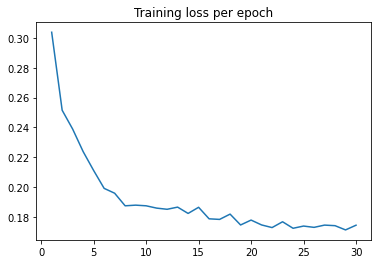

In [ ]:
train(net, train_dataloader, loss, optimizer, num_epochs)

## 5(a). Evaluate the model on some validation data

In [ ]:
# Loss function on validation data
running_loss = 0.0

for i, data in enumerate(val_dataloader, 0):
        # get the inputs of the dataset [x_t, y_t]
        x_t,  y_t  = data

        # Create random subset x_c, y_c from x_t, y_t
        rand = np.random.rand(Npts)
        barrier = np.random.rand()
        mask = rand < barrier
        context = [k for k in range(len(mask)) if mask[k]==True]
        unknown = [k for k in range(len(mask)) if mask[k]==False]
        if len(context)==0: # To ensure that Nc =/= 0
            context = unknown
        x_c = x_t[:,context,:]
        y_c = y_t[:,context,:]
        
        net.eval()
        with torch.no_grad():
            outputs = net(x_c, y_c ,x_t)
        l = loss(outputs, y_t)
        running_loss += l.item()
        
print('Validation loss: {}'.format(running_loss/len(val_dataloader)))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 40, 1])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation loss: 0.17068148600752464


[]

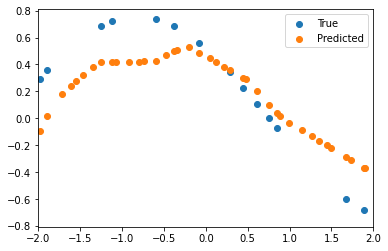

In [ ]:
import matplotlib.pyplot as plt

dataloader_iterator = iter(val_dataloader)
x_t,  y_t  = next(dataloader_iterator)

# Create random subset x_c, y_c from x_t, y_t
rand = np.random.rand(Npts)
barrier = np.random.rand()
mask = rand < barrier
context = [k for k in range(len(mask)) if mask[k]==True]
unknown = [k for k in range(len(mask)) if mask[k]==False]
if len(context)==0: # To ensure that Nc =/= 0
    context = unknown
x_c = x_t[:,context,:]
y_c = y_t[:,context,:]
plt.xlim(-2,2)
outputs = net(x_c, y_c ,x_t)

plt.scatter(x_c[0,:,0].detach().numpy(),y_c[0,:,0].detach().numpy(), label = "True")
plt.scatter(x_t[0,:,0].detach().numpy(),outputs[:,0].detach().numpy(), label = "Predicted")

plt.legend()
plt.plot()

# Test data  

* Test data are stored in a dictionary where each key has the data for a single function $f_a$. We have generated 6 different functions named as `function_num_1`, `function_num_2` and so on. 

In [ ]:
import pickle
path_to_the_pickle = '/content/test_data.pkl'
#path_to_the_pickle = 'test_data.pkl'

test_data =pickle.load(open(path_to_the_pickle,'rb'))
# 6 test functions
i = 2 # i=1,..6
name= 'function_num_{}'.format(i)
x_c=test_data[name]['context_pairs'][0]
y_c=test_data[name]['context_pairs'][1]
x_t =test_data[name]['x']

## 5(b). Plot some predictions

[]

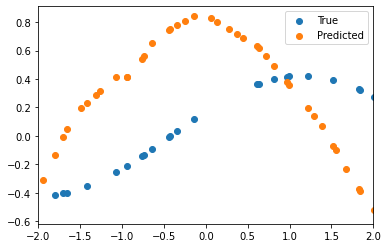

In [ ]:
x_c = test_data['function_num_1']['context_pairs'][0]
y_c = test_data['function_num_1']['context_pairs'][1]
x_t = test_data['function_num_1']['x']

outputs = net(x_c, y_c ,x_t)
plt.xlim(-2,2)

plt.scatter(x_c[0,:,0].detach().numpy(),y_c[0,:,0].detach().numpy(), label = "True")
plt.scatter(x_t[0,:,0].detach().numpy(),outputs[:,0].detach().numpy(), label = "Predicted")

plt.legend()
plt.plot()

[]

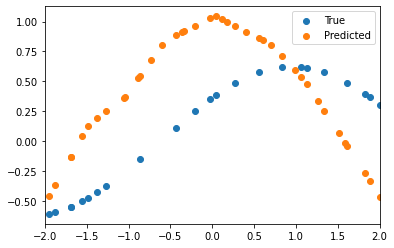

In [ ]:
x_c = test_data['function_num_2']['context_pairs'][0]
y_c = test_data['function_num_2']['context_pairs'][1]
x_t = test_data['function_num_2']['x']

outputs = net(x_c, y_c ,x_t)
plt.xlim(-2,2)

plt.scatter(x_c[0,:,0].detach().numpy(),y_c[0,:,0].detach().numpy(), label = "True")
plt.scatter(x_t[0,:,0].detach().numpy(),outputs[:,0].detach().numpy(), label = "Predicted")

plt.legend()
plt.plot()

[]

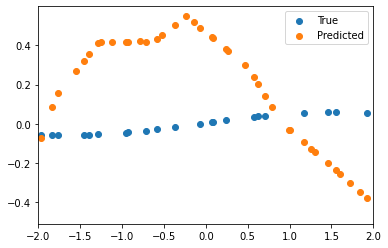

In [ ]:
x_c = test_data['function_num_3']['context_pairs'][0]
y_c = test_data['function_num_3']['context_pairs'][1]
x_t = test_data['function_num_3']['x']

outputs = net(x_c, y_c ,x_t)
plt.xlim(-2,2)

plt.scatter(x_c[0,:,0].detach().numpy(),y_c[0,:,0].detach().numpy(), label = "True")
plt.scatter(x_t[0,:,0].detach().numpy(),outputs[:,0].detach().numpy(), label = "Predicted")

plt.legend()
plt.plot()

[]

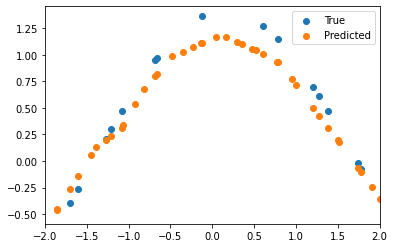

In [ ]:
x_c = test_data['function_num_4']['context_pairs'][0]
y_c = test_data['function_num_4']['context_pairs'][1]
x_t = test_data['function_num_4']['x']

outputs = net(x_c, y_c ,x_t)
plt.xlim(-2,2)

plt.scatter(x_c[0,:,0].detach().numpy(),y_c[0,:,0].detach().numpy(), label = "True")
plt.scatter(x_t[0,:,0].detach().numpy(),outputs[:,0].detach().numpy(), label = "Predicted")

plt.legend()
plt.plot()

[]

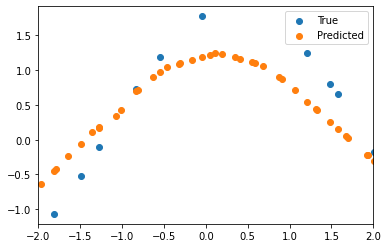

In [ ]:
x_c = test_data['function_num_5']['context_pairs'][0]
y_c = test_data['function_num_5']['context_pairs'][1]
x_t = test_data['function_num_5']['x']

outputs = net(x_c, y_c ,x_t)
plt.xlim(-2,2)

plt.scatter(x_c[0,:,0].detach().numpy(),y_c[0,:,0].detach().numpy(), label = "True")
plt.scatter(x_t[0,:,0].detach().numpy(),outputs[:,0].detach().numpy(), label = "Predicted")

plt.legend()
plt.plot()

[]

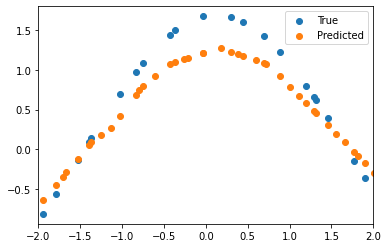

In [ ]:
x_c = test_data['function_num_6']['context_pairs'][0]
y_c = test_data['function_num_6']['context_pairs'][1]
x_t = test_data['function_num_6']['x']

outputs = net(x_c, y_c ,x_t)
plt.xlim(-2,2)

plt.scatter(x_c[0,:,0].detach().numpy(),y_c[0,:,0].detach().numpy(), label = "True")
plt.scatter(x_t[0,:,0].detach().numpy(),outputs[:,0].detach().numpy(), label = "Predicted")

plt.legend()
plt.plot()